In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers as layers

## Load and view data

In [2]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

In [3]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


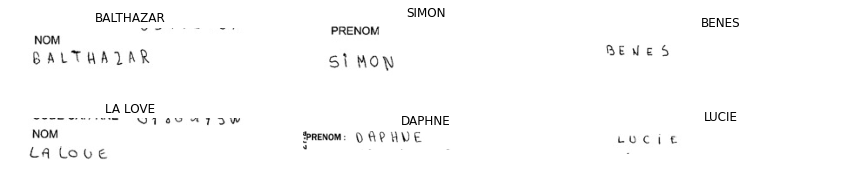

In [4]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

Let's check for NaNs in our label.

In [5]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set       : ", test['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78
Number of NaNs in test set       :  70


In [6]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

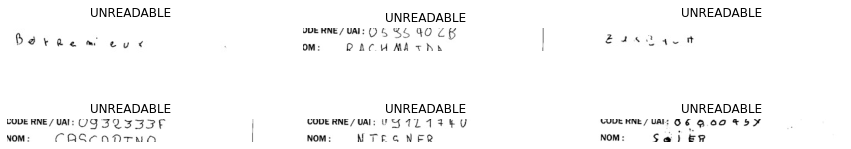

In [7]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [9]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

Reset the index and we are done with cleaning. 

In [10]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

In [11]:
train_y_labels_max=0
train_y_labels_sum=0
train_y_labels_count_freq={}
for i in range(len(train)):
    freq=len(train.loc[i,'IDENTITY'])
    if freq in train_y_labels_count_freq:
        train_y_labels_count_freq[freq]=train_y_labels_count_freq[freq]+1
    else:
        train_y_labels_count_freq[freq]=1
    if freq>train_y_labels_max:
        train_y_labels_max=freq
    train_y_labels_sum = train_y_labels_sum+freq

print('max len:', train_y_labels_max)
print('avg len:', train_y_labels_sum/len(train))


max len: 34
avg len: 6.546531272139367


<BarContainer object of 25 artists>

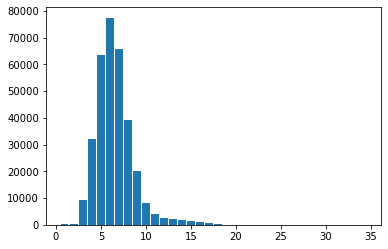

In [12]:
plt.bar(list(train_y_labels_count_freq.keys()),list(train_y_labels_count_freq.values()))

In [13]:
print(train_y_labels_count_freq)

{9: 20161, 5: 63637, 7: 65879, 6: 77412, 8: 39194, 4: 32015, 11: 4064, 12: 2615, 14: 1822, 15: 1468, 10: 8258, 13: 2058, 3: 9095, 16: 1201, 17: 521, 2: 441, 19: 85, 1: 125, 18: 211, 24: 1, 21: 11, 20: 12, 22: 5, 34: 1, 23: 2}


In [14]:
print('train:',len(train),'test:',len(test),'valid:',len(valid))

train: 330294 test: 41289 valid: 41280


In [15]:
train = train[train['IDENTITY'].str.len() < 20]
valid = valid[valid['IDENTITY'].str.len() < 20]
test = test[test['IDENTITY'].str.len() < 20]

In [16]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

In [17]:
print('train:',len(train),'test:',len(test),'valid:',len(valid))

train: 330262 test: 41284 valid: 41279


## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y). 
* The image is then normalized to range [0, 1]

In [18]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

**Image Augmentation**

In [19]:
def augment_image(image):
    # Random Gaussian Blur
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)  # Horizontal flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)  # Vertical flip
        
    if np.random.rand() < 0.7:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)  
        #kernel_size = tuple(np.random.randint(3, 12, 2) * 2 + 1)  
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # Random Brightness Adjustment
    if np.random.rand() < 0.7:
        brightness_factor = np.random.uniform(0.5, 2)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random Contrast Adjustment
    if np.random.rand() < 0.7:
        contrast_factor = np.random.uniform(0.5, 2)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # Random Saturation Adjustment
    if np.random.rand() < 0.7:
        saturation_factor = np.random.uniform(0.5, 2)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # Extract the value (brightness) channel from the HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]

    return image

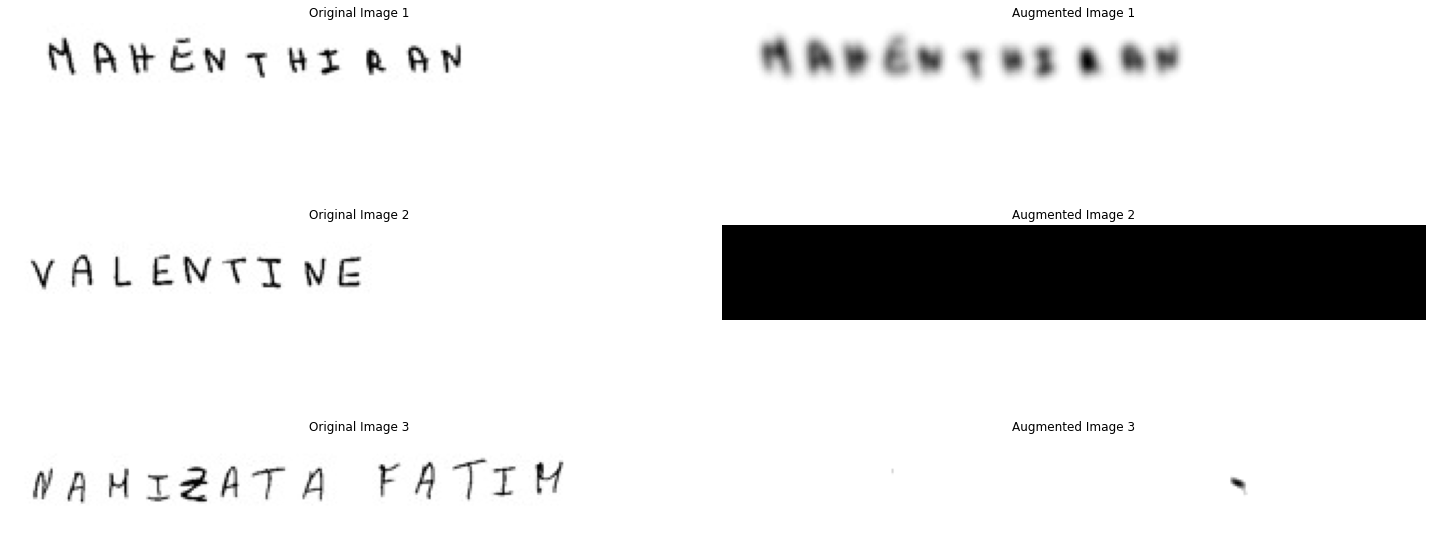

In [20]:
img_paths = ['/kaggle/input/handwriting-recognition/test_v2/test/TEST_0012.jpg',
             '/kaggle/input/handwriting-recognition/test_v2/test/TEST_0007.jpg',
             '/kaggle/input/handwriting-recognition/test_v2/test/TEST_0021.jpg']

# Plot the first three images and their augmented versions
plt.figure(figsize=(20, 10))

for i in range(3):
    img_path = img_paths[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    aug_img = augment_image(img)

    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(aug_img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

The model will be trained on 30000 images and validate on 3000 images

In [21]:
train_size = 40000
valid_size = 4000
test_size = 4000
# train_size = 40
# valid_size = 40
# test_size = 40

In [22]:
img_aug_cnt=0

In [23]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    if random.randint(0, 10) in [1,2,3]:
        image= augment_image(image)
        img_aug_cnt=img_aug_cnt+1
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [24]:
img_aug_cnt

9

In [25]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [26]:
test_x = []

for i in range(test_size):
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

**imp step**

In [27]:
print('train:',len(train_x),'valid:',len(valid_x),'test:',len(test_x))

train: 40 valid: 40 test: 40


In [28]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space). 

In [29]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 20 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [30]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len. 
* **train_label_len** contains the length of each true label (without padding) 
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss. 


In [31]:
# aug_size= 5000

In [32]:
train_y = np.ones([train_size,max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [33]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [34]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= label_to_num(test.loc[i, 'IDENTITY']) 

In [35]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

IndexError: index 100 is out of bounds for axis 0 with size 40

In [36]:
print("train_x:",len(train_x),"train_y",train_y.shape,"vaild_x:",len(valid_x),"valid_y:",valid_y.shape,"test_x:",len(test_x),"test_y:",test_y.shape)

train_x: 40 train_y (40, 20) vaild_x: 40 valid_y: (40, 20) test_x: 40 test_y: (40, 20)


**augmentation**

In [ ]:
# train_size=40000
# for i in range(aug_size):
#     random_number = random.randint(0, train_size-1)
#     img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[random_number, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     image = augment_image(image)
#     image = preprocess(image)
#     image = image/255.
#     ran_num_label = train_y[random_number]
#     ran_label_len = len(train.loc[random_number, 'IDENTITY'])
#     index = train_size+i
#     train_x.append(image)
#     train_label_len[index] = len(train.loc[random_number, 'IDENTITY'])
#     train_y[index, 0:len(train.loc[random_number, 'IDENTITY'])]= label_to_num(train.loc[random_number, 'IDENTITY'])    
#     print(train_y.shape,train_label_len.shape)

In [ ]:
print(len(train_x))

In [ ]:
# from sklearn.utils import shuffle
# train_x = np.array(train_x)
# train_y = np.array(train_y)
# train_x, train_y = shuffle(train_x,train_y)

In [ ]:
print('train:',train_x.shape,'valid:',valid_x.shape,'test:',test_x.shape)

## Building our model


In [ ]:
# input_data = Input(shape=(256, 64, 1), name='input')

# inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

# inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
# inner = Dropout(0.3)(inner)

# inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
# inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
# inner = Dropout(0.3)(inner)

# # CNN to RNN
# inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
# inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# ## RNN
# inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
# inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

# ## OUTPUT
# inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
# y_pred = Activation('softmax', name='softmax')(inner)

# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()

In [ ]:
# from tensorflow.keras.layers import Input, Reshape, Dense, LSTM, Bidirectional, Activation, TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten,Lambda
# from tensorflow.keras.models import Model

# # Define input shape
# input_data = Input(shape=(256, 64, 1), name='input')

# # MobileNet-like architecture for feature extraction
# inner = Conv2D(32, (3, 3), padding='same', name='conv1')(input_data)
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

# inner = Conv2D(64, (3, 3), padding='same', name='conv2')(inner)
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
# inner = Dropout(0.3)(inner)

# inner = Conv2D(128, (3, 3), padding='same', name='conv3')(inner)
# inner = Conv2D(128, (3, 3), padding='same', name='conv4')(inner)
# inner = BatchNormalization()(inner)
# inner = Activation('relu')(inner)
# inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
# inner = Dropout(0.3)(inner)

# # Reshape to fit LSTM input
# reshaped_output = Reshape(target_shape=(64, 1024))(inner)

# # LSTM layers
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(reshaped_output)
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# # Output layer
# y_pred = TimeDistributed(Dense(num_of_characters, activation='softmax'), name='dense2')(inner)

# # Create the model
# model = Model(inputs=input_data, outputs=y_pred)

# # Print model summary
# model.summary()

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU

# # Define input shape
# input_shape = (256, 64, 1)  # Assuming input shape of (256, 64, 3)

# # Define input layer
# input_data = Input(shape=input_shape, name='input_7')


# # Duplicate the single channel across all three channels
# # x = Concatenate()([input_data, input_data, input_data])
# x = Conv2D(3, (1, 1), padding='same')(input_data)

# # Define MobileNet layers
# x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
# x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid', name='conv1')(x)
# x = BatchNormalization(name='conv1_bn')(x)
# x = ReLU(name='conv1_relu')(x)

# x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', name='conv_dw_1')(x)
# x = BatchNormalization(name='conv_dw_1_bn')(x)
# x = ReLU(name='conv_dw_1_relu')(x)
# x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_pw_1')(x)
# x = BatchNormalization(name='conv_pw_1_bn')(x)
# x = ReLU(name='conv_pw_1_relu')(x)

# x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
# x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', name='conv_dw_2')(x)
# x = BatchNormalization(name='conv_dw_2_bn')(x)
# x = ReLU(name='conv_dw_2_relu')(x)
# x = Conv2D(128, (1, 1), strides=(1, 1), padding='same', name='conv_pw_2')(x)
# x = BatchNormalization(name='conv_pw_2_bn')(x)
# x = ReLU(name='conv_pw_2_relu')(x)

# x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', name='conv_dw_3')(x)
# x = BatchNormalization(name='conv_dw_3_bn')(x)
# x = ReLU(name='conv_dw_3_relu')(x)
# x = Conv2D(128, (1, 1), strides=(1, 1), padding='same', name='conv_pw_3')(x)
# x = BatchNormalization(name='conv_pw_3_bn')(x)
# x = ReLU(name='conv_pw_3_relu')(x)

# inner = MaxPooling2D(pool_size=(1, 2), name='max3')(x)
# inner = Dropout(0.3)(inner)

# # CNN to RNN
# inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
# inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
# inner = Dropout(0.3)(inner)

# ## RNN
# inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
# inner = Dropout(0.3)(inner)

# inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)
# inner = Dropout(0.3)(inner)

# ## OUTPUT
# inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
# y_pred = Activation('softmax', name='softmax')(inner)

# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()


In [1]:
# Add drop layers
# from keras.applications import VGG16
# from tensorflow.keras.layers import Concatenate,Flatten
# input_data = Input(shape=(256, 64, 1), name='input')
# x = Concatenate()([input_data, input_data, input_data])
# vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 64, 3))

# # # Freeze VGG16 layers
# # for layer in vgg_model.layers:
# #     layer.trainable = False

# # Add VGG16 model to your network
# vgg_output = vgg_model(x)

# # Add additional layers after VGG16
# inner = Flatten()(vgg_output)
# # inner = Dense(256, activation='relu', name='dense1')(inner)
# # inner = Dropout(0.5)(inner)

# # CNN to RNN
# inner = Reshape(target_shape=((64, 128)), name='reshape')(inner)
# inner = Dense(64, activation='relu', name='dense2')(inner)

# # RNN
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# # Output layer
# y_pred = Dense(num_of_characters, activation='softmax', name='output')(inner)

# # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()


In [54]:
# squeezenet
from tensorflow.keras.layers import Concatenate, Conv2D, MaxPooling2D, Flatten, Reshape, Dense, LSTM, Bidirectional, Input, Activation

def fire_module(x, fire_id, squeeze=16, expand=64):
    """
    Create a fire module with squeeze and expand layers.
    """
    squeeze_channels = squeeze
    expand1_channels = expand
    expand3_channels = expand

    # Squeeze layer
    squeeze_layer = Conv2D(squeeze_channels, (1, 1), activation='relu', padding='same', name='fire{}/squeeze'.format(fire_id))(x)

    # Expand layer 1x1
    expand1_layer = Conv2D(expand1_channels, (1, 1), activation='relu', padding='same', name='fire{}/expand1x1'.format(fire_id))(squeeze_layer)

    # Expand layer 3x3
    expand3_layer = Conv2D(expand3_channels, (3, 3), activation='relu', padding='same', name='fire{}/expand3x3'.format(fire_id))(squeeze_layer)

    # Concatenate the outputs
    output = Concatenate(axis=-1, name='fire{}/concatenate'.format(fire_id))([expand1_layer, expand3_layer])

    return output

# Define input shape
input_data = Input(shape=(256, 64, 1), name='input')

# SqueezeNet architecture
conv1 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='valid', name='conv1')(input_data)
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(conv1)

fire2 = fire_module(pool1, fire_id=2, squeeze=16, expand=64)
fire3 = fire_module(fire2, fire_id=3, squeeze=16, expand=64)
pool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(fire3)
pool3 = Dropout(0.4)(pool3)

fire4 = fire_module(pool3, fire_id=4, squeeze=32, expand=128)
fire5 = fire_module(fire4, fire_id=5, squeeze=32, expand=128)
pool5 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(fire5)
pool5 = Dropout(0.4)(pool5)

fire6 = fire_module(pool5, fire_id=6, squeeze=48, expand=192)
fire7 = fire_module(fire6, fire_id=7, squeeze=48, expand=192)
fire8 = fire_module(fire7, fire_id=8, squeeze=64, expand=256)
fire8 = Dropout(0.4)(fire8)

# Flatten and Dense layers
flatten = Flatten(name='flatten')(fire8)
# dense1 = Dense(512, activation='relu', name='dense1')(flatten)

# Reshape for LSTM
reshaped_output = Reshape(target_shape=(64, 360))(flatten)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(reshaped_output)

# LSTM layers
lstm1 = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
lstm2 = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(lstm1)

# Output layer
y_pred = Dense(num_of_characters, activation='softmax', name='output')(lstm2)

# Create model
model = Model(inputs=input_data, outputs=y_pred)
model.summary()


Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 127, 31, 64)  640         input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 63, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2/squeeze (Conv2D)          (None, 63, 15, 16)   1040        pool1[0][0]                      
______________________________________________________________________________________

In [49]:
# # mobilenetv2
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import Concatenate,Flatten

# input_data = Input(shape=(256, 64, 1), name='input')
# x = Concatenate()([input_data, input_data, input_data])

# # Load MobileNetV2 without the top (classification) layers
# mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 64, 3))

# # Pass input through MobileNetV2
# mobilenet_output = mobilenet_v2(x)

# # Additional layers after feature extraction
# inner = Flatten()(mobilenet_output)
# inner = Dropout(0.4)(inner)

# # inner = Dense(64, activation='relu', name='dense1')(inner)

# # CNN to RNN
# inner = Reshape(target_shape=(64, 320), name='reshape')(inner)
# inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# # LSTM layers
# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)

# inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# # Output layer
# y_pred = Dense(num_of_characters, activation='softmax', name='output')(inner)

# # Create model
# model = Model(inputs=input_data, outputs=y_pred)
# model.summary()


9412608/9406464 [==============================] - 1s 0us/step
Model: "functional_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 64, 3)   0           input[0][0]                      
                                                                 input[0][0]                      
                                                                 input[0][0]                      
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 8, 2, 1280)   2257984     concatenate[0][0]                
________________________

In [50]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [55]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [56]:
model_final.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 127, 31, 64)  640         input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 63, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2/squeeze (Conv2D)          (None, 63, 15, 16)   1040        pool1[0][0]                      
______________________________________________________________________________________

In [ ]:
print(train_x.shape, train_y.shape, train_input_len.shape, train_label_len.shape)

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# def ctc_loss(y_true, y_pred):
#     # Assuming y_true is not needed for CTC loss calculation
#     return ctc_lambda_func([y_pred, labels, input_length, label_length])

## Train our model

In [57]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=64,verbose=1)
# ,callbacks=[early_stopping]

Epoch 1/60
1/1 [==============================] - 2s 2s/step - loss: 180.1823 - val_loss: 178.6387
Epoch 2/60
1/1 [==============================] - 0s 213ms/step - loss: 180.0205 - val_loss: 178.4745
Epoch 3/60
1/1 [==============================] - 0s 237ms/step - loss: 179.8480 - val_loss: 178.2863
Epoch 4/60
1/1 [==============================] - 0s 241ms/step - loss: 179.6484 - val_loss: 178.0672
Epoch 5/60
1/1 [==============================] - 0s 205ms/step - loss: 179.4124 - val_loss: 177.8092
Epoch 6/60
1/1 [==============================] - 0s 190ms/step - loss: 179.1300 - val_loss: 177.5027
Epoch 7/60
1/1 [==============================] - 0s 223ms/step - loss: 178.7904 - val_loss: 177.1352
Epoch 8/60
1/1 [==============================] - 0s 224ms/step - loss: 178.3775 - val_loss: 176.6903
Epoch 9/60
1/1 [==============================] - 0s 223ms/step - loss: 177.8699 - val_loss: 176.1458
Epoch 10/60
1/1 [==============================] - 0s 225ms/step - loss: 177.2302 - v

KeyboardInterrupt: 

## Check model performance on validation set

In [ ]:
# preds = model.predict(valid_x)
# decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
#                                    greedy=True)[0][0])

# prediction = []
# for i in range(valid_size):
#     prediction.append(num_to_label(decoded[i]))

In [ ]:
preds = model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = test.loc[0:test_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

## Some predictions on test set

In [ ]:
# test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(35000,35006):
    ax = plt.subplot(2, 3, i-35000+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# model_final.save('version_best.h5')

In [ ]:
# model.summary()

In [ ]:
# model_final.save('my_handwriting_model_2.h5')

In [ ]:
model.save('mnet_model2.h5')
model.save('my_handwriting_model_1.keras')

In [ ]:
# # Define the CTC loss function for loading
# def ctc_loss(y_true, y_pred):
#     return ctc_lambda_func([y_pred, labels, input_length, label_length])

# # Load the model using the custom_objects parameter
# loaded_model = tf.keras.models.load_model('my_handwriting_model_1.h5', custom_objects={'ctc': ctc_loss})
# # loaded_model.compile(loss={'ctc': ctc_loss}, optimizer=Adam(lr=0.0001))
# # model = tf.keras.models.load_model('my_handwriting_model_2.h5')

In [ ]:
# # test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

# plt.figure(figsize=(15, 10))
# for i in range(35000,35006):
#     ax = plt.subplot(2, 3, i-35000+1)
#     img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap='gray')
    
#     image = preprocess(image)
#     image = image/255.
#     pred = loaded_model.predict(image.reshape(1, 256, 64, 1))
#     decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
#                                        greedy=True)[0][0])
#     plt.title(num_to_label(decoded[0]), fontsize=12)
#     plt.axis('off')
    
# plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# tflite_model = converter.convert()

## Ways to improve the model 

* Use more training samples. This will help the model to learn and generalise better. I have used only 10% of the images as the entire training set cannot be loaded into kaggle's memory. 
* There are multiple images in the training set which are not at all legible to the human eye. Removing such images will help in model's learning. 

*P.S : This is my first Kaggle notebook. Any feedback would be highly appreciated*